In [ ]:
import torch

if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
from  google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install optuna
!pip install seqeval
!pip install sentencepiece
!git clone https://github.com/huggingface/transformers
!cd transformers && pip install .
!pip install farasapy
!pip install pyarabic
!git clone https://github.com/aub-mind/arabert

In [ ]:
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
all_datasets= []

In [ ]:
class Dataset:
    def __init__(
        self,
        name,
        train,
        test,
        label_list,
    ):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [ ]:
!unzip "/content/drive/MyDrive/ANERcorp-CamelLabSplits.zip"

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
def read_ANERcorp(path):
  with open(path,'r',encoding='utf-8') as f:
    data = []
    sentence = []
    label = []
    for line in f:
      if line=='\n':
        if len(sentence) > 0:
          data.append((sentence,label))
          sentence = []
          label = []
        continue
      splits = line.split()
      sentence.append(splits[0])
      label.append(splits[1])
    if len(sentence) > 0:
      data.append((sentence,label))
  return data

In [ ]:
ANERCorp_path = './ANERcorp-CamelLabSplits/'
data_train = read_ANERcorp(ANERCorp_path+'ANERCorp_CamelLab_train.txt')
data_test = read_ANERcorp(ANERCorp_path+'ANERCorp_CamelLab_test.txt')

print(Counter([ label for sentence in data_test for label in sentence[1]]))
print(Counter([ label for sentence in data_train for label in sentence[1]]))

label_list = list(Counter([ label for sentence in data_test for label in sentence[1]]).keys())
print(label_list)

Counter({'O': 21633, 'B-PERS': 858, 'B-LOC': 668, 'I-PERS': 641, 'B-ORG': 450, 'I-ORG': 275, 'B-MISC': 235, 'I-MISC': 165, 'I-LOC': 83})
Counter({'O': 111921, 'B-LOC': 3776, 'B-PERS': 2721, 'I-PERS': 2205, 'B-ORG': 1576, 'I-ORG': 1115, 'B-MISC': 888, 'I-LOC': 525, 'I-MISC': 375})
['B-LOC', 'O', 'B-PERS', 'I-PERS', 'B-ORG', 'I-LOC', 'I-ORG', 'B-MISC', 'I-MISC']


Training Sentence Lengths: 


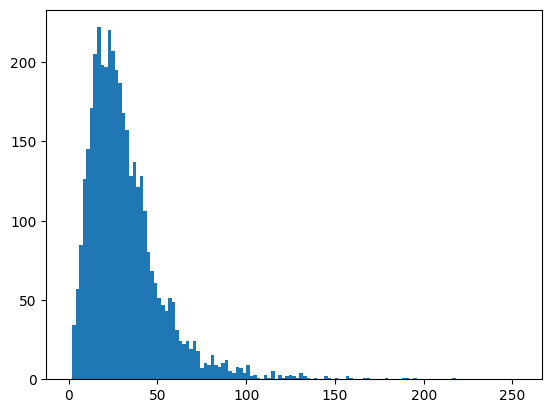

1
Testing Sentence Lengths: 


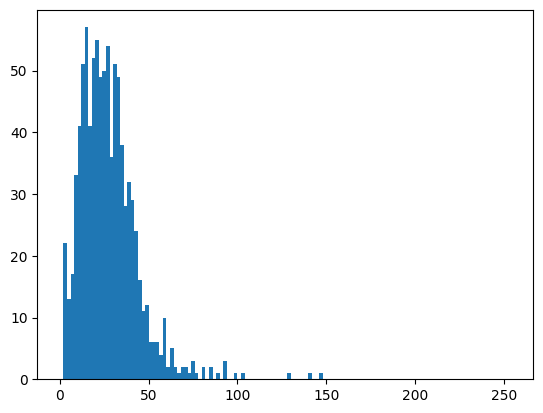

0


In [ ]:
print("Training Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_train],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 512 for sentence in data_train]))

print("Testing Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_test],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 256 for sentence in data_test]))

In [ ]:
data_AJGT = Dataset("ANERCorp", data_train, data_test, label_list)
all_datasets.append(data_AJGT)

In [ ]:
from arabert.preprocess import ArabertPreprocessor
import numpy as np
from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer
from transformers import Trainer , TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import resample
import logging
import torch
import optuna

In [ ]:
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

In [ ]:
for x in all_datasets:
  print(x.name)

ANERCorp


In [ ]:
dataset_name = 'ANERCorp'
model_name = 'aubmindlab/bert-base-arabertv02'
task_name = 'tokenclassification'

In [ ]:
for d in all_datasets:
  if d.name==dataset_name:
    selected_dataset = d
    print('Dataset found')
    break

Dataset found


In [ ]:
class NERDataset:
  def __init__(self, texts, tags, label_list, model_name, max_length):
    self.texts = texts
    self.tags = tags
    self.label_map = {label: i for i, label in enumerate(label_list)}
    self.preprocessor = ArabertPreprocessor(model_name.split("/")[-1])
    self.pad_token_label_id = torch.nn.CrossEntropyLoss().ignore_index

    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    self.max_length = max_length


  def __len__(self):
    return len(self.texts)

  def __getitem__(self, item):
    textlist = self.texts[item]
    tags = self.tags[item]

    tokens = []
    label_ids = []
    for word, label in zip(textlist, tags):
      clean_word = self.preprocessor.preprocess(word)
      word_tokens = self.tokenizer.tokenize(clean_word)

      if len(word_tokens) > 0:
        tokens.extend(word_tokens)
        label_ids.extend([self.label_map[label]] + [self.pad_token_label_id] * (len(word_tokens) - 1))

    special_tokens_count = self.tokenizer.num_special_tokens_to_add()
    if len(tokens) > self.max_length - special_tokens_count:
      tokens = tokens[: (self.max_length - special_tokens_count)]
      label_ids = label_ids[: (self.max_length - special_tokens_count)]

    tokens += [self.tokenizer.sep_token]
    label_ids += [self.pad_token_label_id]
    token_type_ids = [0] * len(tokens)

    tokens = [self.tokenizer.cls_token] + tokens
    label_ids = [self.pad_token_label_id] + label_ids
    token_type_ids = [0] + token_type_ids

    input_ids = self.tokenizer.convert_tokens_to_ids(tokens)


    attention_mask = [1] * len(input_ids)

    padding_length = self.max_length - len(input_ids)

    input_ids += [self.tokenizer.pad_token_id] * padding_length
    attention_mask += [0] * padding_length
    token_type_ids += [0] * padding_length
    label_ids += [self.pad_token_label_id] * padding_length

    assert len(input_ids) == self.max_length
    assert len(attention_mask) == self.max_length
    assert len(token_type_ids) == self.max_length
    assert len(label_ids) == self.max_length

    return {
        'input_ids' : torch.tensor(input_ids, dtype=torch.long),
        'attention_mask' : torch.tensor(attention_mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
        'labels' : torch.tensor(label_ids, dtype=torch.long)
    }

In [ ]:
label_map = { v:index for index, v in enumerate(selected_dataset.label_list) }
print(label_map)

train_dataset = NERDataset(
    texts=[x[0] for x in selected_dataset.train],
    tags=[x[1] for x in selected_dataset.train],
    label_list=selected_dataset.label_list,
    model_name=model_name,
    max_length=256
    )

test_dataset = NERDataset(
    texts=[x[0] for x in selected_dataset.test],
    tags=[x[1] for x in selected_dataset.test],
    label_list=selected_dataset.label_list,
    model_name=model_name,
    max_length=256
    )

{'B-LOC': 0, 'O': 1, 'B-PERS': 2, 'I-PERS': 3, 'B-ORG': 4, 'I-LOC': 5, 'I-ORG': 6, 'B-MISC': 7, 'I-MISC': 8}


In [ ]:
def model_init():
    return AutoModelForTokenClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

In [ ]:
inv_label_map = {i: label for i, label in enumerate(label_list)}

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)

    batch_size, seq_len = preds.shape

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            if label_ids[i, j] != torch.nn.CrossEntropyLoss().ignore_index:
                out_label_list[i].append(inv_label_map[label_ids[i][j]])
                preds_list[i].append(inv_label_map[preds[i][j]])

    return preds_list, out_label_list

def compute_metrics(p):
    preds_list, out_label_list = align_predictions(p.predictions,p.label_ids)
    return {
        "accuracy_score": accuracy_score(out_label_list, preds_list),
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
    }

In [ ]:
training_args = TrainingArguments(
    output_dir= "./train",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    gradient_accumulation_steps = 2,
    num_train_epochs= 8,

    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,

    greater_is_better = True,
    seed = 42,lr_scheduler_type = 'cosine',disable_tqdm = False
  )

In [ ]:
steps_per_epoch = (len(selected_dataset.train)// (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps))
total_steps = steps_per_epoch * training_args.num_train_epochs
print(steps_per_epoch)
print(total_steps)
warmup_ratio = 0.1

124
992


In [ ]:
training_args = TrainingArguments(
    output_dir= "./train",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    gradient_accumulation_steps = 2,
    num_train_epochs= 8,
    warmup_steps = total_steps*warmup_ratio,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,

    greater_is_better = True,
    seed = 42,lr_scheduler_type = 'cosine',disable_tqdm = False
  )



In [ ]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy Score,Precision,Recall,F1
0,No log,0.168362,0.960146,0.781193,0.756899,0.768854
2,No log,0.142247,0.967788,0.823397,0.798511,0.810763
2,No log,0.144166,0.969069,0.830401,0.806395,0.818222
4,No log,0.144989,0.970229,0.827586,0.819974,0.823762
4,0.211600,0.151844,0.970950,0.836991,0.818660,0.827724
6,0.211600,0.152624,0.970990,0.835268,0.819536,0.827327
6,0.211600,0.154714,0.971110,0.833037,0.821726,0.827343
7,0.211600,0.157353,0.970629,0.834449,0.819098,0.826702


TrainOutput(global_step=992, training_loss=0.11632251258819334, metrics={'train_runtime': 1641.3054, 'train_samples_per_second': 19.365, 'train_steps_per_second': 0.604, 'total_flos': 4137504029655552.0, 'train_loss': 0.11632251258819334, 'epoch': 7.97})

In [ ]:
inv_label_map = inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("output_dir")
train_dataset.tokenizer.save_pretrained("output_dir")

{0: 'B-LOC', 1: 'O', 2: 'B-PERS', 3: 'I-PERS', 4: 'B-ORG', 5: 'I-LOC', 6: 'I-ORG', 7: 'B-MISC', 8: 'I-MISC'}


('output_dir/tokenizer_config.json',
 'output_dir/special_tokens_map.json',
 'output_dir/vocab.txt',
 'output_dir/added_tokens.json',
 'output_dir/tokenizer.json')

In [ ]:
inv_label_map = inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("/content/drive/MyDrive/ner_savee")
train_dataset.tokenizer.save_pretrained("/content/drive/MyDrive/ner_savee")

{0: 'B-LOC', 1: 'O', 2: 'B-PERS', 3: 'I-PERS', 4: 'B-ORG', 5: 'I-LOC', 6: 'I-ORG', 7: 'B-MISC', 8: 'I-MISC'}


('/content/drive/MyDrive/ner_savee/tokenizer_config.json',
 '/content/drive/MyDrive/ner_savee/special_tokens_map.json',
 '/content/drive/MyDrive/ner_savee/vocab.txt',
 '/content/drive/MyDrive/ner_savee/added_tokens.json',
 '/content/drive/MyDrive/ner_savee/tokenizer.json')

In [ ]:
test_model = AutoModelForTokenClassification.from_pretrained("output_dir")
TOKENIZER =  AutoTokenizer.from_pretrained("output_dir")

In [ ]:
def predict_sent(sentences):

    input_ids  = TOKENIZER.encode(sentences, return_tensors='pt')


    with torch.no_grad():
        test_model.to('cpu')
        output = test_model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


    tokens = TOKENIZER.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(inv_label_map[label_idx])
            new_tokens.append(token)


    for token, label in zip(new_tokens, new_labels):
        print("{}\t{}".format(label, token))


In [ ]:
sentence2 = "الامم المتحدة توجد في مصر"
predict_sent(sentence2)


O	[CLS]
B-ORG	الامم
I-ORG	المتحدة
O	توجد
O	في
B-LOC	مصر
B-ORG	[SEP]
